## Classifier Performance: Constructing a QSO catalogue
#### Plot to show performance when constructing a catalogue
In this notebook, we load the results from all of our classifiers on a DESI-like subset of the BOSS DR12Q Superset, and compare the results in the context of constructing a QSO catalogue. We define different strategies for combining the classifiers' classifications, and assess which of these is preferable.

In [1]:
import copy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [2]:
figsize = (12,8)
fontsize = 18

temp_output_loc = '/global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/'

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
## RR parameters

## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

## Load the RR data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q.fits'
data['RR'] = utils.load_rr_data(f_rr)

## Load the new RR data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q_test.fits'
data['RRnew'] = utils.load_rr_data(f_rr)

## Load the RRngp data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q_ngp.fits'
data['RRngp'] = utils.load_rr_data(f_rr)

## Load BOSS pipeline data.
f_pipe = temp_output_loc+'/results/dr12pipe_results/dr12pipe_sdr12q.fits'
#f_pipe = temp_output_loc+'/dr14pipe_results/dr14pipe_sdr12q.fits'
data['PIPE'] = utils.load_rr_data(f_pipe)

## Load the QN single exposure data.
f_qn = temp_output_loc+'/results/qn_results/qn_performance_vs_snr/qn_modelsingexp_testsingexp.fits'
data['QNsingexp'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the QN data.
f_qn = temp_output_loc+'/results/qn_results/qn_performance_vs_training_set_size/qn_10pc.fits'
data['QN'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the SQ data.
f_sq = temp_output_loc+'/results/sq_results/sq_sdr12q.fits'
data['SQ'] = utils.load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)

### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [6]:
data_table = utils.reduce_data_to_table(data,truth,
                                  include_c_qn=include_c_qn,
                                  include_p_sq=include_p_sq)
data_table[:5]

INFO: 294024 common spectra


OBJ_ID,SPEC_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR,Z_RRnew,Z_RRngp,Z_PIPE,Z_QNsingexp,Z_QN,Z_SQ,CLASS_RR,CLASS_RRnew,CLASS_RRngp,CLASS_PIPE,CLASS_QNsingexp,CLASS_QN,CLASS_SQ,ISQSO_RR,ISQSO_RRnew,ISQSO_RRngp,ISQSO_PIPE,ISQSO_QNsingexp,ISQSO_QN,ISQSO_SQ,C_QNsingexp [6],C_QN [6],P_SQ,ZWARN_RR,ZWARN_RRnew,ZWARN_RRngp,ZWARN_PIPE
int64,int64,int64,float64,str8,bool,float64,float64,float64,float64,float64,float64,float64,str8,str8,str8,str8,str8,str8,str8,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,int64,int64,int64,int64
87897905,3586551810016,2,2.242,QSO,True,2.238,2.237,2.236,2.242,2.242,2.244,2.233,QSO,QSO,QSO,QSO,QSO,QSO,QSO,True,True,True,True,True,True,True,1.000 .. 0.000,1.000 .. 0.000,0.958,0,0,0,0
87896919,3586551810032,2,0.000,STAR,False,0.001,0.689,0.751,-0.003,0.647,2.366,0.647,STAR,GALAXY,GALAXY,STAR,NONQSO,NONQSO,NONQSO,False,False,False,False,False,False,False,0.000 .. 0.000,0.000 .. 0.000,0.151,0,4,4,4
87897024,3586551810036,2,0.000,STAR,False,-0.000,-0.000,-0.000,-0.000,2.093,2.108,2.303,STAR,GALAXY,GALAXY,STAR,NONQSO,NONQSO,NONQSO,False,False,False,False,False,False,False,0.000 .. 0.000,0.000 .. 0.000,0.059,0,0,0,0
94817272,3586551810038,2,2.196,QSO,True,2.170,0.191,0.191,2.166,2.181,2.204,2.179,QSO,GALAXY,GALAXY,QSO,QSO,QSO,QSO,True,False,False,True,True,True,True,1.000 .. 0.000,0.541 .. 0.000,0.780,0,0,0,64
87897405,3586551810040,2,0.000,STAR,False,-0.000,-0.000,-0.000,-0.000,1.687,2.112,-1.000,STAR,STAR,STAR,STAR,NONQSO,NONQSO,NONQSO,False,False,False,False,False,False,False,0.000 .. 0.000,0.000 .. 0.000,-1.000,0,0,0,0


In [7]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
len(data_table)

287996

### Evaluate performance of classifiers at constructing a QSO catalogue.
xxx

In [8]:
data_table_archive = copy.deepcopy(data_table)

In [9]:
# Define some parameters
dv_max = 6000. #km/s
show_correctwrongzbin = False
zbins = [(0.9,2.1),(2.1,None)]
desi_nqso=[1.3*10**6,0.8*10**6]

In [10]:
## Define the strategies
stratdefs = {}

## Single classifiers.
# QN definitions.
c_kwargs = {'c_th': 0.3, 'n_detect': 1}
strat = strategy.Strategy('qn')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN'] = {'isqso': pred.isqso, 'z': pred.z}

# RR definitions.
c_kwargs = {'zwarn': False}
strat = strategy.Strategy('rr')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RR'] = {'isqso': pred.isqso, 'z': pred.z}

# RR incl. zwarn definitions.
c_kwargs = {'zwarn': None}
strat = strategy.Strategy('rr')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RRzwarn'] = {'isqso': pred.isqso, 'z': pred.z}

# PIPE definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'PIPE'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['PIPE'] = {'isqso': pred.isqso, 'z': pred.z}

# SQ definitions.
c_kwargs = {'p_min': 0.32}
strat = strategy.Strategy('sq')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['SQ'] = {'isqso': pred.isqso, 'z': pred.z}

# QN 2line definitions.
c_kwargs = {'c_th': 0.3, 'n_detect': 2}
strat = strategy.Strategy('qn')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN2line'] = {'isqso': pred.isqso, 'z': pred.z}

# RRnew definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'RRnew'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RRnew'] = {'isqso': pred.isqso, 'z': pred.z}

# RRngp definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'RRngp'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RRngp'] = {'isqso': pred.isqso, 'z': pred.z}


## Simple & | combinations of classifiers.
# QN|RR definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.3, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
strat = strategy.Strategy('qnorrr')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN|RR'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&RR definitions
c_kwargs = {'qn_kwargs': {'c_th': 0.3, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False},
            'dv_max': dv_max}
strat = strategy.Strategy('qnandrr')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RR'] = {'isqso': pred.isqso, 'z': pred.z}

# QN|PIPE definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.3, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'rr_name': 'PIPE'}
strat = strategy.Strategy('qnorrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN|PIPE'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&PIPE definitions
c_kwargs = {'qn_kwargs': {'c_th': 0.3, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False},
            'dv_max': dv_max}
cf_kwargs = {'rr_name': 'PIPE'}
strat = strategy.Strategy('qnandrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&PIPE'] = {'isqso': pred.isqso, 'z': pred.z}

# QN|RR zRR definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.3, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False},
            'zchoice': 'RR'}
strat = strategy.Strategy('qnorrr')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['| zRR'] = {'isqso': pred.isqso,'z': pred.z}

# QN&RR zRR definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.3, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False},
            'dv_max': dv_max,
            'zchoice': 'RR'}
strat = strategy.Strategy('qnandrr')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['& zRR'] = {'isqso': pred.isqso,'z': pred.z}


## Strategies involving VI.
# RR+VI definitions
c_kwargs = {}
strat = strategy.Strategy('rrplusvi')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RR+VI'] = {'isqso': pred.isqso, 'z': pred.z}

# QN+VI definitions.
c_kwargs = {'c_th_hi': 0.9, 'c_th_lo': 0.1, 'n_detect': 1}
strat = strategy.Strategy('qnplusvi')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN+VI'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&RR+VI definition 1.
# Classifies as QSO when QN has c>cth or if RR classifies as QSO without zwarn.
# Asks for VI when if one classifier says QSO but the other doesn't, or if the redshifts disagree.
c_kwargs = {'qn_kwargs': {'c_th': 0.3, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
strat = strategy.Strategy('qnandrrplusvi')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RR+VI'] = {'isqso': pred.isqso, 'z': pred.z, 'label': 'QN&RR\n+VI'}

# QN&RR+VI definitions 2.
# Classifies as QSO when QN has c>cth_hi or if RR classifies as QSO without zwarn.
# Asks for VI if QN says c>cth_hi but RR has a zwarn.
# Also if RR says QSO without zwarn, and QN says cth_lo<c<cth_hi.
# Rejects if either QN says c<cth_lo or 
c_kwargs = {'c_th_hi': 0.9, 'c_th_lo': 0.1, 'n_detect': 1}
strat = strategy.Strategy('qnandrrplusviadv')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RR+VI adv.'] = {'isqso': pred.isqso, 'z': pred.z, 'label': 'QN&RR\n+VI adv.'}

INFO: RR+VI sends 12438/287996 (4.3%) spectra to VI
INFO: QN+VI sends 1728/287996 (0.60%) spectra to VI
INFO: QN&RR+VI sends 9259/287996 (3.2%) spectra to VI
INFO: RR&QN+VI adv. sends 2949/287996 (1.0%) spectra to VI


/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/strategy.py:76: RuntimeWarning: divide by zero encountered in true_divide
  dv = (300000.*abs(z1-z2)/(1+ztrue))


In [11]:
# Check that we haven't accidentally overwritten any data.
assert (data_table==data_table_archive).all()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


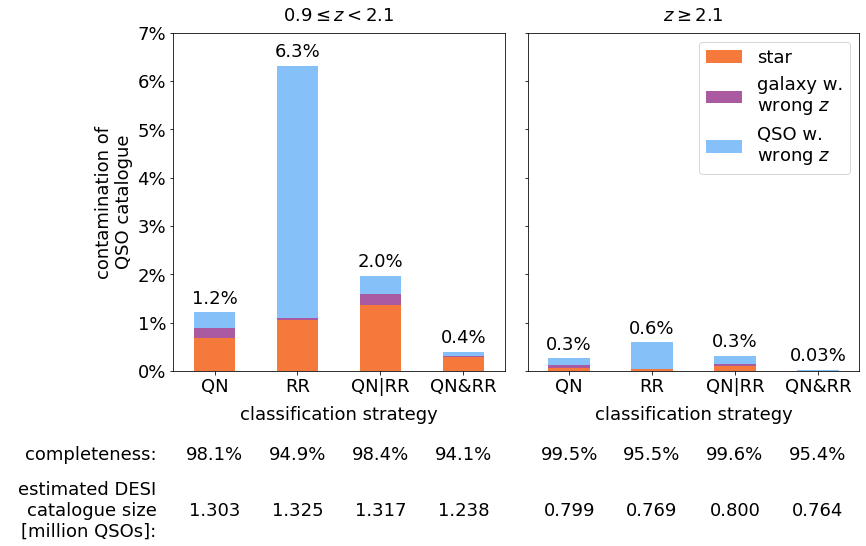

In [12]:
## Plot comparing QN, RR and simple combinations.
plot_strategies = ['QN','RR','QN|RR','QN&RR']
filename = '../plots/classifier_performance_constructing_a_catalogue.pdf'
ymax = 0.07

# Make the plot.
strategies = {s:stratdefs[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


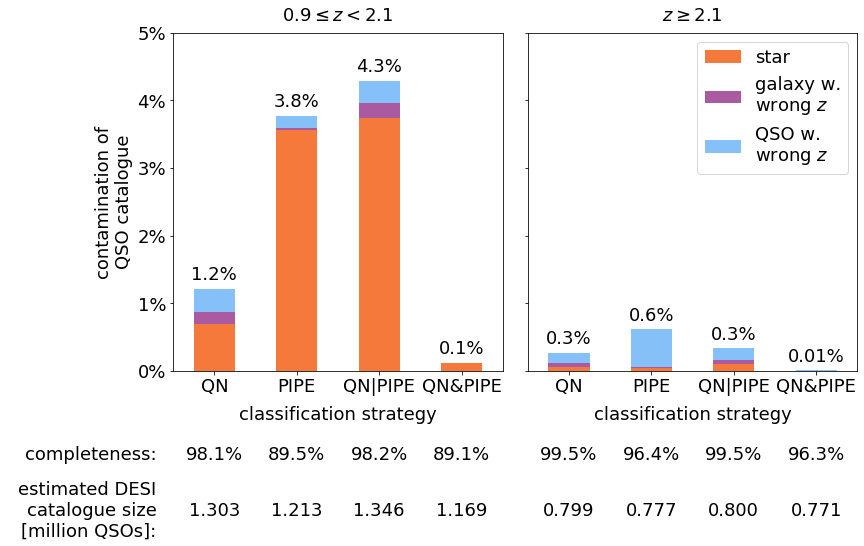

In [13]:
## As above but swapping redrock for DR12 pipeline
plot_strategies = ['QN','PIPE','QN|PIPE','QN&PIPE']
filename = '../plots/classifier_performance_constructing_a_catalogue_dr12pipe.pdf'
ymax = 0.05

# Make the plot.
strategies = {s:stratdefs[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


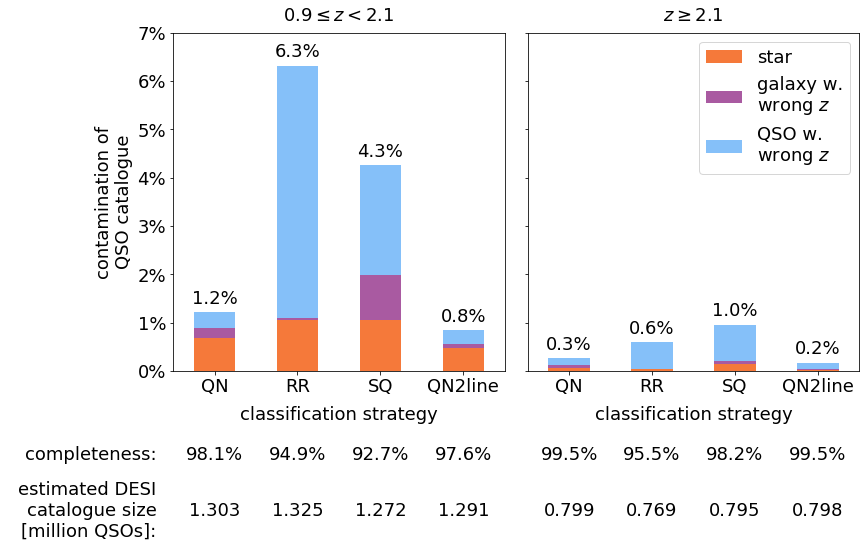

In [14]:
## Plot to compare different classifiers
plot_strategies = ['QN','RR','SQ','QN2line']
filename = '../plots/classifier_performance_constructing_a_catalogue_altstrat.pdf'
ymax = 0.07

# Make the plot.
strategies = {s:stratdefs[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


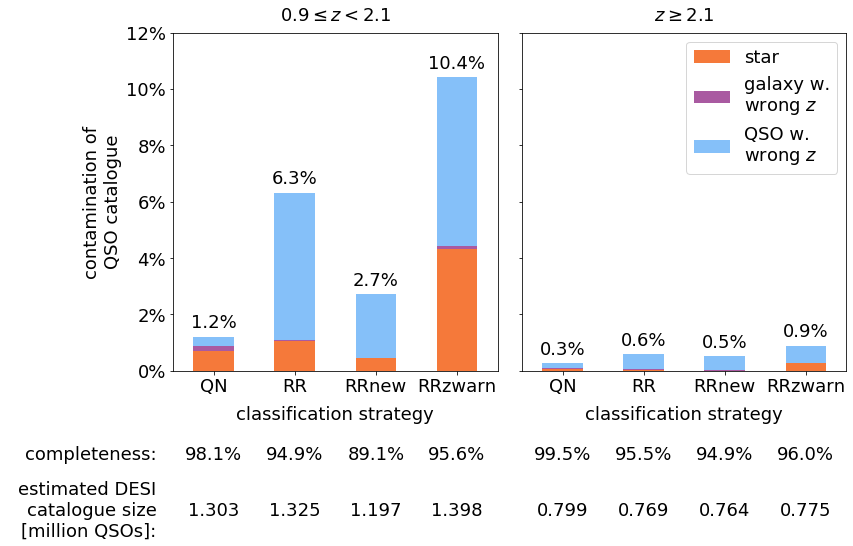

In [15]:
## Plot to show different redrock options.
plot_strategies = ['QN','RR','RRnew','RRzwarn']
filename = '../plots/classifier_performance_constructing_a_catalogue_rrnew.pdf'
ymax = 0.12

# Make the plot.
strategies = {s:stratdefs[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


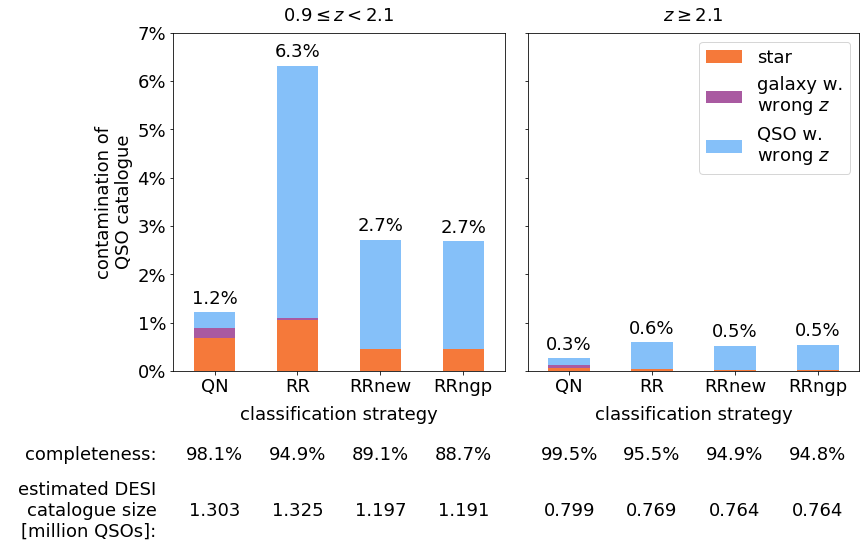

In [16]:
## Plot to show different redrock spCFrame interpolation methods.
plot_strategies = ['QN','RR','RRnew','RRngp']
filename = '../plots/classifier_performance_constructing_a_catalogue_rrtest.pdf'
ymax = 0.07

# Make the plot.
strategies = {s:stratdefs[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


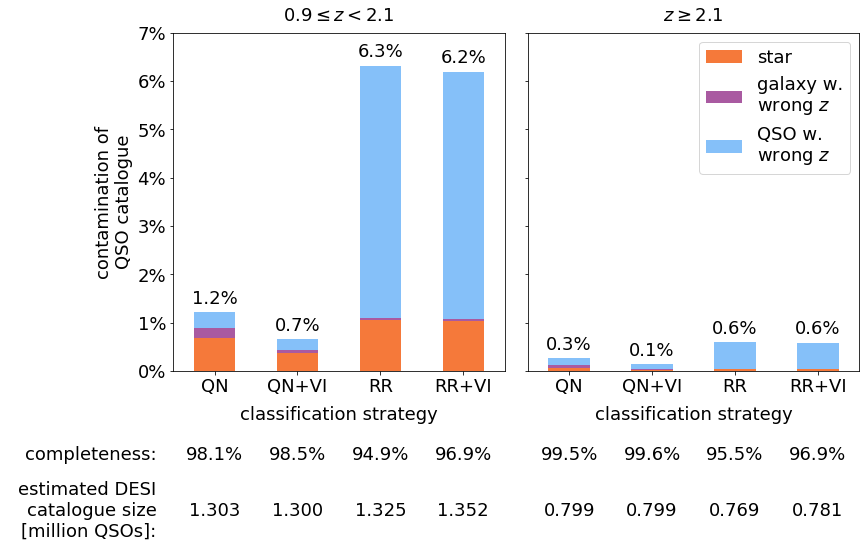

In [17]:
## Plot to test introducing VI on ``difficult'' spectra.
plot_strategies = ['QN','QN+VI','RR','RR+VI']
filename = '../plots/classifier_performance_constructing_a_catalogue_plusvi.pdf'
ymax = 0.07

# Make the plot.
strategies = {s:stratdefs[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


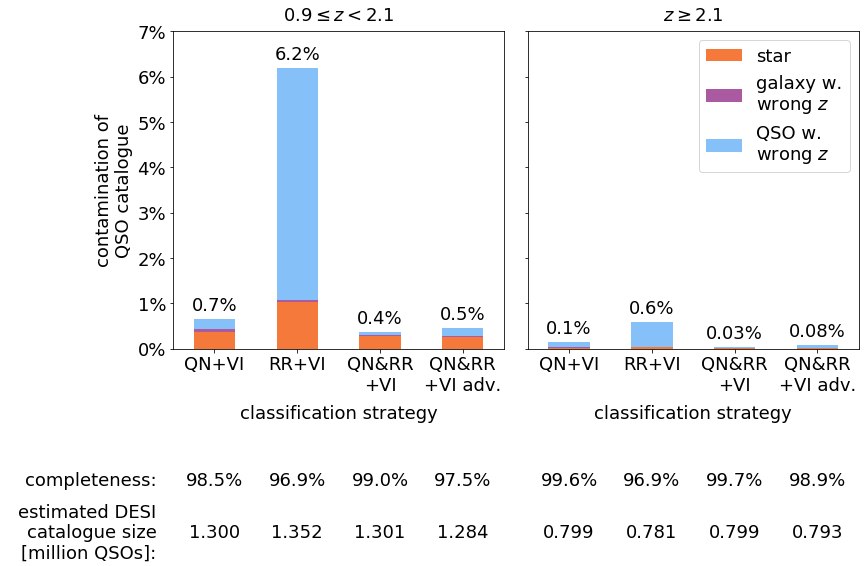

In [18]:
## Plot to further test introducing VI on ``difficult'' spectra.
plot_strategies = ['QN+VI','RR+VI','QN&RR+VI','QN&RR+VI adv.']
filename = '../plots/classifier_performance_constructing_a_catalogue_complex.pdf'
ymax = 0.07

# Make the plot.
strategies = {s:stratdefs[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


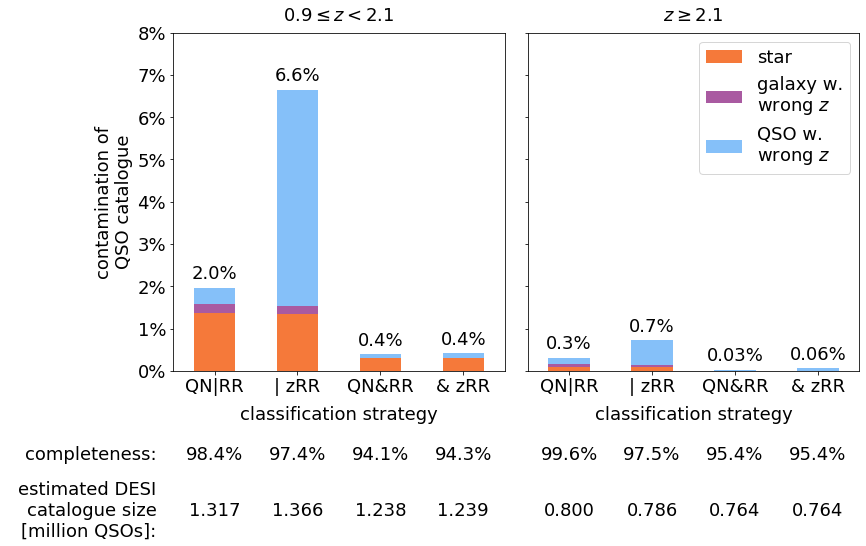

In [19]:
## Compare choice of redshift in simple combination strategies.
plot_strategies = ['QN|RR','| zRR','QN&RR','& zRR']
filename = '../plots/classifier_performance_constructing_a_catalogue_zrr.pdf'
ymax = 0.08

# Make the plot.
strategies = {s:stratdefs[s] for s in plot_strategies}
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax)
plt.show()